# Geochemical Facies Analysis using Machine Learning

**Brendon Hall, Enthought**

The practice of extracting insights from large datasets has certainly caught mainstream attention in recent years.  Terms like 'Big Data' and 'multivariate statistics' pervade industry literature and conference show floors.  Geoscientists, however, have been wrangling massive multivariate datasets since the first seismic survey. While there have been recent advances in machine learning (eg. deep neural networks) many of the multivariate approaches to learning from data have been around for a long time. There are also a plethora of libraries available that implement these methods.  One of the most popular libraries is `scikit-learn` (http://scikit-learn.org/stable/), a collection of machine learning libraries in Python.  It contains many tools for data mining and analysis including classification, clustering and regression algorithms.  

In this tutorial we demonstrate how dimensionality reduction and unsupervised machine learning can be used to analyze X-ray flourescence measurements of cutting samples.  Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a smaller set of variables that are better at describing the variation within the dataset. Clustering is an unsupervised machine learning technique that learns an optimal grouping from the data itself and doesn't require training data.  The groups consist of samples with similar characteristics, which can be considered as distinct geochemical facies.  This will be implemented using Python, the `scikit-learn` library and other popular Python data science tools. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.preprocessing import scale
from sklearn.decomposition import FactorAnalysis
from sklearn.cluster import KMeans

# Visualization libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

## XRF Cuttings Analysis

X-ray flourescence (XRF) is becoming a common wellsite cuttings analysis technique (Carr et al, 2014).  Portable XRF provide rapid elemental composition measurements of cuttings as they are drilled.  These devices measure the flourescent x-rays emitted by a sample when illuminated by an energetic X-ray source.  Elements in the sample will emit X-rays certain specific wavelengths, and the spectrum of the emitted x-rays can be measured and used to quantify the amount of the corresponding elements in present in the sample.  Trends in element concentration can be use to infer sediment depositional environment, sources, and indicate conditions conducive to the preservation of organic material. XRF data can be used to for geologic characterization, optimize well placement and provide additional guidance for geosteering.

The data for this tutorial consists of XRF measurements of cuttings from the lateral section of an unconventional well.  The cuttings measurements are made at approximately 10m intervals.  In this case the raw data consists of 22 measurements for each sample.  Each measurement gives the weight percentage of a component.  The data is read from a `csv` file into a dataframe using the `pandas` library, which provides many convenient data structures and tools for data science. 

In [2]:
geochem_df = pd.read_csv('XRF_dataset.csv')
geochem_df.describe()

,Depth,Quartz,K-Feldspar,Plagioclase,Chlorite,IlliteSmectiteMica,Calcite,Ankerite/Dolomite,Pyrite,Organics,...,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,SO3,Cl,Zr
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,...,269.000000,269.00000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,4664.828625,41.417881,1.736580,6.150558,2.677546,12.673606,28.290372,3.726840,1.356134,1.970855,...,1.825093,0.18223,0.500056,19.175948,0.634331,0.951896,0.107212,1.005390,0.108327,189.496729
std,911.581632,5.213285,1.589391,2.764867,0.800505,5.003480,8.453997,2.429544,0.320557,0.753070,...,0.615196,0.10246,0.721303,6.253697,0.184312,0.445288,0.107977,0.314675,0.071580,79.106943
min,3173.970000,27.050000,0.000000,0.150000,0.550000,0.000000,10.960000,0.000000,0.410000,0.000000,...,0.380000,0.01000,0.020000,6.170000,0.160000,0.250000,0.000000,0.400000,0.020000,38.480000
25%,3905.490000,38.170000,0.380000,3.900000,2.140000,8.920000,22.130000,1.750000,1.170000,1.530000,...,1.440000,0.15000,0.170000,14.240000,0.540000,0.640000,0.060000,0.740000,0.060000,128.810000
50%,4637.010000,41.750000,1.410000,6.080000,2.700000,12.820000,27.410000,3.610000,1.360000,1.930000,...,1.750000,0.18000,0.310000,19.150000,0.600000,0.910000,0.080000,1.010000,0.090000,187.850000
75%,5447.780000,44.650000,2.480000,8.200000,3.180000,15.180000,32.510000,5.360000,1.550000,2.410000,...,2.080000,0.20000,0.450000,22.480000,0.700000,1.110000,0.110000,1.200000,0.140000,227.460000
max,6296.640000,53.560000,6.520000,13.740000,5.460000,27.050000,57.150000,11.950000,2.270000,5.570000,...,4.310000,1.25000,3.560000,35.860000,1.390000,2.430000,1.040000,2.850000,0.370000,471.710000


## Feature Engineering

In machine learning, the term *feature* is used to refer to the attributes of the objects being considered that can be used to describe, cluster and classify them.  In this case, the objects being studied are cuttings samples, and the features are the 22 XRF measurements.  We can use *feature engineering* to augment this dataset.  This refers to the process of using domain knowledge to create new features that help machine learning algorithms discriminate the data.  

In geochemistry, elements are used as proxies that give hints to the physical, chemical or biological events that were occuring during its formation.  Ratios of certain elements can indicate the relative strength of various effects.  For example, The Si/Zr ratio can used to record high biogenic silica relative to terrestrial detrital input (associated with sandstone and siltstone).  The Si/Al ratio is used as a proxy for biogenic silica to aluminous clay (Croudace and Rothwell, 2015).  The Zr/Al ratio proxy for terrigenous input, geochemical behavior of Zr suggests that this ratio can be used as a proxy for grain size (Calvert and Pederson, 2007).

In [3]:
geochem_df['Si/Zr'] = geochem_df['SiO2'] / geochem_df['Zr']
geochem_df['Si/Al'] = geochem_df['SiO2'] / geochem_df['Al2O3']
geochem_df['Zr/Al'] = geochem_df['Zr'] / geochem_df['Al2O3']

## Dimensionality Reduction

Not surprisingly, multivariate datasets are characterized by the fact that they contain plenty of variables.  This richness can be used to explain complex behaviour that can't be captured with a single observation.  Multivariate methods allow us to consider changes in several observations simultaneously.  With many observations it is quite likely that the changes we observe are related to a smaller number of underlying causes.  Dimensionality Reduction is the process of using the correlations in the observed data to reveal a more parsimonious underlying model that explains the variation in the observed data.

Exploratory factor analysis (EFA) reduces the number of variables by identifying the underlying *latent factors* present in the dataset.  These factors cannot be measured directly, can be determined only by measuring manifest properties.  For example, in the case of our geochemical dataset, a *shaliness* factor could be associated with high XX and XX readings. EFA assumes that the observations are a linear combination of the underlying factors, plus some Gaussian noise.    A related dimensionality reduction technique is principle component analysis (PCA).  In EFA, the factors are responsible for causing the responses in the measured variables.  PCA determines components that are weighted linear combinations of the observations. 

Before applying EFA, the dataset should be standardized.  If the measurements were made using different scales, this can affect the weights assigned to each factor.  This preprocessing operation rescales each variable to have zero mean and unit variance. 

In [4]:
data = geochem_df.ix[:, 2:]
data = scale(data)

EFA requires that the number of factors to be extracted is specified *a-priori*.  It is often not immediately obvious how many factors should be specified.  Many authors have proposed rules over the years (eg. Preacher et al, 2013).  One simple approach (known as the Kaiser criterion) involves looking at the eigenvalues of the covariance matrix of the data, and counting the number above a threshold (typically 1.0).  In the Figure , there are 7 eigenvalues greater than 1.0 (dashed red line), suggesting the number of factors to be extracted.

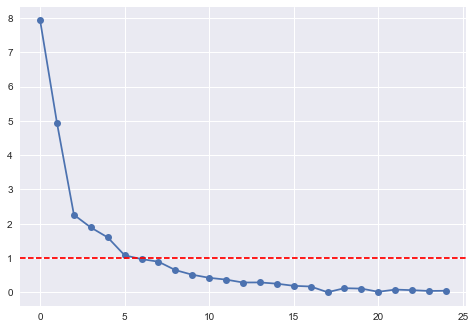

In [5]:
fig = plt.figure()
plt.plot(np.linalg.eig(np.cov(data, rowvar=False))[0], 'o-')
#plt.title('Eigenvalues of covariance matrix')
plt.axhline(y=1.0, color='r', linestyle='--')
fig.savefig('images/1_eigs.png', dpi=300, bbox_inches='tight')

The scikit-learn library contains a FactorAnalysis module that can be used to extract the 7 factors.  This is done by creating a factor analysis object and fitting the model to the data.

In [6]:
fa_model = FactorAnalysis(n_components = 6)
fa_model.fit(data)
factor_data = fa_model.transform(data)

In [7]:
# create a dataframe consisting of the factor values for each data point
factor_df = pd.DataFrame(factor_data, columns=['Comp {}'.format(i) for i in range(0,6)])
factor_df['Well Name'] = geochem_df['Well Name']
factor_df['Depth'] = geochem_df['Depth']

# create a dataframe with the factor loadings associated with each observation
factors =  pd.DataFrame(fa_model.components_, columns=geochem_df.ix[:, 2:].columns.values)

### Interpreting the factors

The factors can now be examined to interpret the underlying properties they represent.  Figure 2 shows the *factor loadings* associated with a factor.  The loading score indicates the correlation between the factor and the observed variables.  In this case, the factor is associated with high values of plagioclase, illite/smectite/mica, pyrite and organic material.  We could interpret this factor as representing the organic rich clay content.  Similar interpretations can be given to the other factors by observing their loading scores.

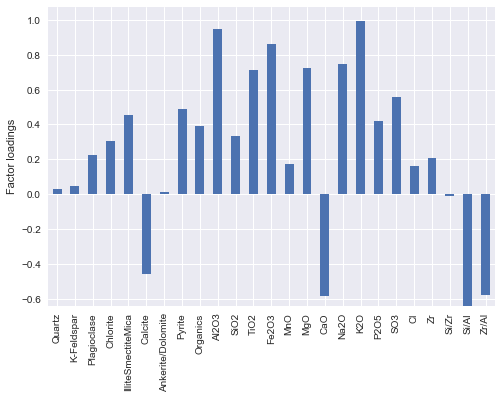

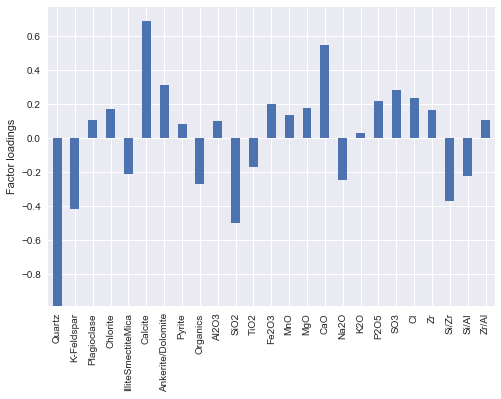

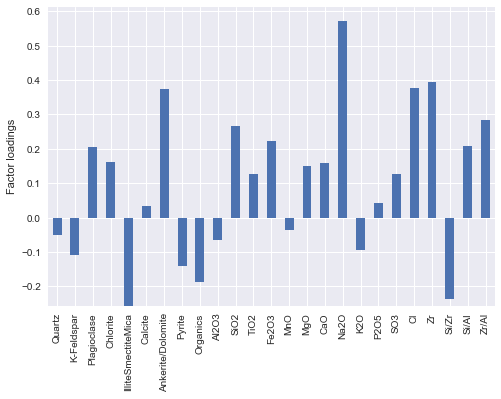

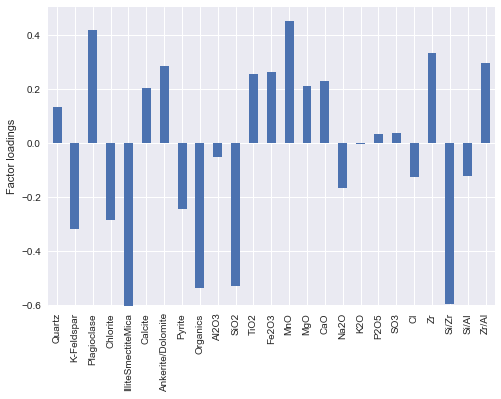

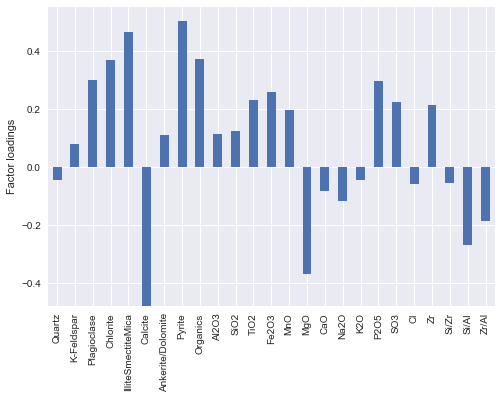

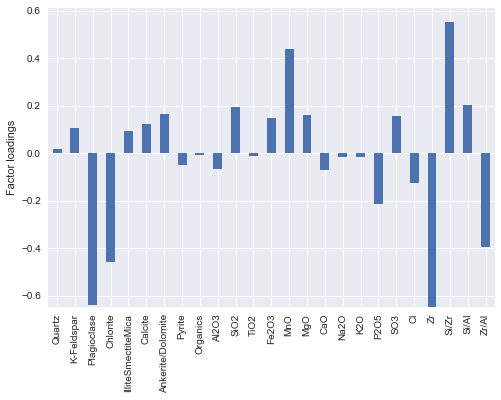

In [8]:
for factor_id in range(0, factors.shape[0]):
    fig = plt.figure()
    #plt.title('Factor {}'.format(factor_id))
    plt.ylabel('Factor loadings')
    factors.ix[factor_id].plot(kind='bar')
    #if factor_id == 3:
        #fig.savefig('images/2_Factor_interp.png', dpi=300, bbox_inches='tight')
        #break

## Clustering
   
The factor analysis has reduced the initial collection of 25 XRF features in a reduced set of 6 factors that account for most of the variation in the data.  A logical next step would be using these factors to group the cutting samples by their common geochemical traits, or *geochemical facies*.  Cluster analysis is a suitable approach for assigning a common facies label to similar samples. Clustering attempts to group samples so that those in the same group (or cluster) are more similar than those in other clusters.  Cluster analysis is one class of techniques that fall under the category of *unsupervised* machine learning.  These approaches are used to infer structure from the data itself, without the use of labeled training data to guide the model. 

The [K-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) algorithm clusters data by trying to separate samples in $n$ groups of equal variance.  The algorithm locates the optimal cluster centroids by minimizing the distance between each point in a cluster and the closest centroid. The algorithm has three steps.  It initializes by picking locations for the initial $n$ centroids (often random samples from the dataset).  Next, each sample is assigned to one of the $n$ groups according to the nearest centroid.  New centroids are then calculated by finding the mean values of each sample in each group.  This is repeated until the difference between subsequent centroid positions falls below a given threshold.

Similar to EFA, K-Means requires that the number of clusters be specified before running the algorithm.  There are a number of approaches to finding the optimal number of clusters.  The goal is to choose the minimum number of clusters that accurately partition the dataset.  These range from the relatively simple 'elbow method' to more rigorous techniques involving the Bayesian information criterion and optimizing the Gaussian nature of each cluster (Hamerly and Elkan, 2003).  Figure 3 demonstrates the 'elbow method' applied to this dataset.  The sum of the squared distance of each point to the nearest cluster centroid is plotted for an increasing number of clusters.  As the number of clusters is increased, the error decreases as the clusters better fit the data. The elbow of the curve represents the point of diminishing returns where increasing the number of clusters doesn't reduce the error appreciably.  Figure 3 suggests that about 7 clusters would be adequate for this dataset.

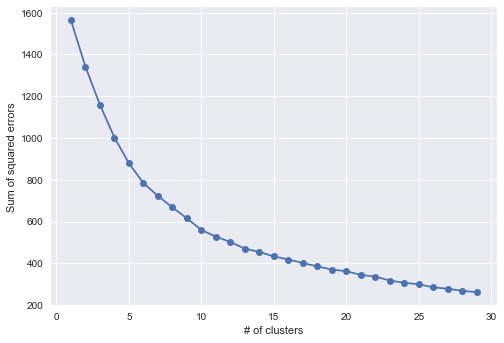

In [10]:
inertias = []
means = []
maxK = 30
for k in range(1, maxK):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(factor_data)
    means.append(k)
    inertias.append(kmeans.inertia_)

fig = plt.figure()
plt.plot(means, inertias, 'o-')
plt.xlabel('# of clusters')
plt.ylabel('Sum of squared errors')
fig.savefig('images/3_k_means.png', dpi=300, bbox_inches='tight')

The K-means algorithm in scikit-learn is used to cluster the reduced dataset.  Similar to the factor analysis, this is done by creating a K-means model and fitting the factor dataset.

In [11]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(factor_data)

# add the cluster ids to the dataset
factor_df['Cluster'] = kmeans.labels_
geochem_df['Cluster'] = factor_df['Cluster']

### Interpreting the clusters

Each sample in the dataset has now been assigned to one of seven clusters.  If we are going  to interpret these clusters as geochemical facies, it is useful to inspect the to inspect the geochemical signature of each cluster. Figure 4 contains a series of box plots that show the distribution of a small subset of measurements across each of the 7 clusters.  Box plots depict 5 descriptive statistics; the horizontal lines of the colored rectangle show the first quartile, median and third quartile.  The arms show the minimum and maximum.  Outliers are shown as black diamonds.  This plot is generated using the statistical visualization library `seaborn` [https://seaborn.pydata.org/](https://seaborn.pydata.org/).

Figure 4A indicates that Cluster 2 is characterized by a relatively high (and variable) Si/Zr ratio.  Cluster 4 has a high Zr/Al ratio (4B, 4C) and cluster 3 has a high MgO signature.  This can be done for each measurement to build up a geologic interpretation of each cluster.  

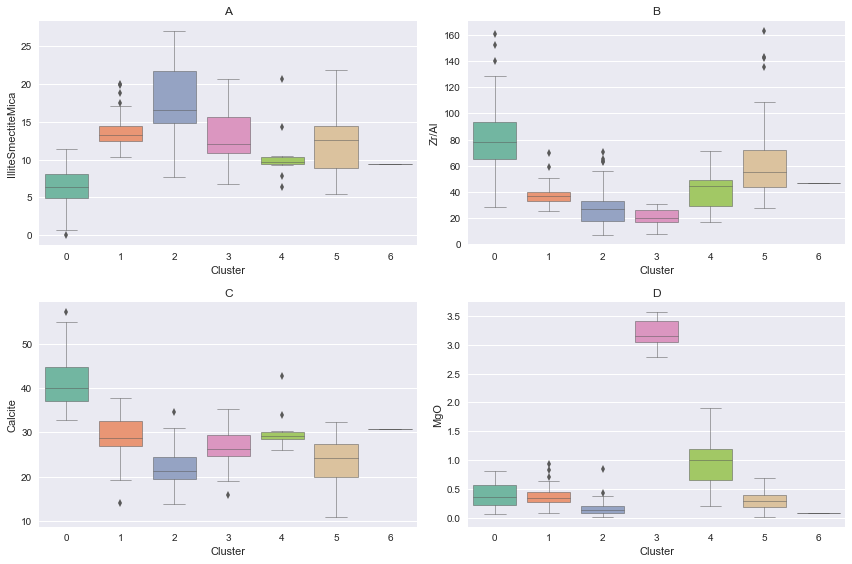

In [20]:
# set some colors for the different facies
facies_colors = sns.color_palette("Set2", 8)
# let's not use the yellow
del facies_colors[5]

# simple command for one plot
# sns.boxplot(x='Cluster', y='Si/Zr', linewidth=0.5,
#             data=geochem_df)

fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.boxplot(x='Cluster', y='IlliteSmectiteMica', linewidth=0.5,
            data=geochem_df, ax=ax[0,0],
            palette=facies_colors).set_title("A")
sns.boxplot(x='Cluster', y='Zr/Al', linewidth=0.5,
            data=geochem_df, ax=ax[0,1],
            palette=facies_colors).set_title("B")
sns.boxplot(x='Cluster', y='Calcite', linewidth=0.5,
            data=geochem_df, ax=ax[1,0],
            palette=facies_colors).set_title("C")
sns.boxplot(x='Cluster', y='MgO', linewidth=0.5,
            data=geochem_df, ax=ax[1,1],
            palette=facies_colors).set_title("D")

plt.tight_layout()
fig.savefig('images/4_Cluster_fingerprint.png', dpi=300, bbox_inches='tight')

In [2]:
def make_facies_log_plot(logs, facies_colors, label):
    # reset to original matplotlib style
    # seaborn doesn't look as good for this
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    #make sure logs are sorted by depth 
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs[label].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 10))
    ax[0].plot(logs['Si/Zr'], logs.Depth, '-g')
    ax[1].plot(logs['Zr/Al'], logs.Depth, '-')
    ax[2].plot(logs['Calcite'], logs.Depth, '-', color='0.5')
    ax[3].plot(logs['MgO'], logs.Depth, '-', color='r')
    im=ax[4].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=6)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((14*' ').join(['Clust 1', 'Clust 2', 'Clust 3', 
                                'Clust 4', 'Clust 5', 'Clust 6', 'Clust 7']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("Si/Zr")
    ax[0].set_xlim(logs['Si/Zr'].min(),logs['Si/Zr'].max())
    ax[0].set_ylabel('MD [m]')
    ax[0].grid(b=False)
    ax[1].set_xlabel("Zr/Al")
    ax[1].set_xlim(logs['Zr/Al'].min(),logs['Zr/Al'].max())
    ax[1].grid(b=False)
    ax[2].set_xlabel("Calcite")
    ax[2].set_xlim(logs['Calcite'].min(),logs['Calcite'].max())
    ax[2].grid(b=False)
    ax[3].set_xlabel("MgO")
    ax[3].set_xlim(logs['MgO'].min(),logs['MgO'].max())
    ax[3].grid(b=False)
    ax[4].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[4].set_xticklabels([])
    #f.suptitle(logs.iloc[0]['Well Name'], fontsize=14,y=0.9)
    return f

## Visualizing results

Now we have organized every cutting measurement into 7 geochemical facies (clusters), we can visualize the classification in a log plot to better understand how the facies transition to one another in the context of a well.  The right column of Figure 5 shows the clusters assigned to each sample using a unique color, indexed by measured depth (MD).  The other columns show 4 of the corresponding geochemical measurements.  Similar plots could be made for the other wells in the dataset and used to identify common intervals.

In [3]:
f = make_facies_log_plot(geochem_df[geochem_df['Well Name'] == 'Well 1'],
        facies_colors, 'Cluster')
f.savefig('images/5_Well1_logs.png', dpi=300, bbox_inches='tight')

NameError: name 'geochem_df' is not defined

This analysis provides data that can be used for geosteering horizontal wells.  This is useful in areas that lack a distinctive gamma ray signature. Classifing the geochemical facies of a cuttings sample can be used to help pinpoint the location of the well given an exisiting chemo-stratigraphic framework.  To build up this framework, it is helpful to plot the geochemical facies along the well path.  Figure 6 shows the trajectory (TVD vs. MD) the well, with the different facies colored using the same scheme as Figure 5.  This can be used to build a psuedo-vertical profile and help identify specific zones as the well porpoises up and down along its length.

In [23]:
filename = 'well_trajectory.csv'
trajectory_df = pd.read_csv(filename)

# combine the stat facies curve 
well1_df = geochem_df[geochem_df['Well Name'] == 'Well 1']

In [24]:
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline
x = trajectory_df.MD.values
y = trajectory_df.TVD.values
f = interp1d(x,y)

well1_df = well1_df.assign(TVD = f(well1_df.Depth.values))

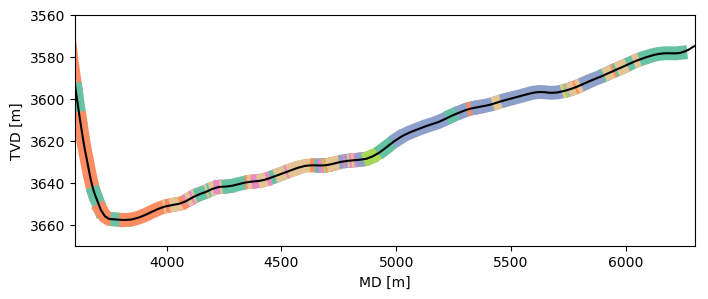

In [25]:
last_row = len(well1_df)
fig = plt.figure(figsize=(8,3))

x = []
y = []
for index, row in well1_df.iterrows():
    if index == last_row-1:
        break
    next_row = well1_df.ix[index+1]
    current_facies = row['Cluster']
    next_facies = well1_df.ix[index+1, 'Cluster']
    #print('current: %d, next: %d\n'%(current_facies, next_facies))
    x.append(row.Depth)
    y.append(row.TVD)
    if current_facies != next_facies:
        x.append(next_row.Depth)
        y.append(next_row.TVD)
        plt.plot(x,y,color=facies_colors[current_facies],linewidth=10)
        x = []
        y = []
plt.xlim([3600, 6300])
plt.ylim([3560, 3670])
plt.gca().invert_yaxis()

plt.plot(well1_df.Depth, well1_df.TVD, color='k',label='Well 1')
#plt.title('Well 1')
plt.xlabel('MD [m]')
plt.ylabel('TVD [m]')
plt.show()
fig.savefig('images/6_Well1_trajectory.png', dpi=300, bbox_inches='tight')

This tutorial has demonstrated how dimensionality reduction and unsupervised machine learning can be used to understand and analyze XRF measurements of cuttings to determine geochemical facies.  Exploratory factor analysis yields insight into the underlying rock properties that are changing across the reservoir.  K-means clustering is used to organize similar samples into a smaller number of groups that can be interpreted as geochemical facies.  This can be used to correlate formation tops between wells and provide data necessary for geosteering.

The code shown in this article demonstrates how to perform most of this analysis using Python and some common toolboxes.  For the full code used to generate these results, please see the github repo at [www.github.com/brendonhall/xrf_tutorial](www.github.com/brendonhall/xrf_tutorial).

## References

Carr, R., Yarbrough, L., Lentz, N., Neset, K., Lucero, B. and Kirst, T. (2014) *On-Site XRF Analysis of Drill Cuttings in the Williston Basin*. URTeC Denver, Colorado, USA. doi:[10.15530/urtec-2014-1934308](https://www.crossref.org/iPage?doi=10.15530%2Furtec-2014-1934308)

Calvert, S. and Pedersen, T. (2007). *Elemental proxies for paleoclimatic and palaeoceanographic variability in marine sediments: interpretation and application*. Developments in Marine Geology. 1. 568-644.

Croudace, I. W., and R. G. Rothwell. *Micro-XRF Studies of Sediment Cores*. Springer, 2015.

Davis, J. C. *Statistical and Data Analysis in Geology*. J. Wiley, 1986.

Hamerly, G. and Elkan, C. (2003) *Learning the k in k-means*. Advances in Neural Information Processing Systems 16, edited by Thrun, S., Saul, L. K. and Sch&ouml;lkopf, B. MIT Press, 281-288.

Iwamori, H., Yoshida, K., Nakamura, H. Kuwatani, T., Hamada, M., Haraguchi, S. and Ueki, K. (2017) *Classification of geochemical data based on multivariate statistical analyses: Complementary roles of cluster, principal component, and independent component analyses*. Geochemisty, Geophysics, Geosystems. 18(3).  994–1012. doi:[10.1002/2016GC006663](http://onlinelibrary.wiley.com/doi/10.1002/2016GC006663/abstract)

Preacher K.J., Zhang G., Kim C. and Mels G. (2013) *Choosing the Optimal Number of Factors in Exploratory Factor Analysis: A Model Selection Perspective*. Multivariate Behav Res. 48(1).

Waskom, M., et al. (2017) Seaborn, statistical data visualization library. v0.8.1 doi: [10.5281/zenodo.883859](https://doi.org/10.5281/zenodo.883859)
